## Edge Colorizer

This notebook goes through an image processing pipeline for detecting and coloring edges in an image.

In [1]:
import glob
import numpy as np
import scipy.stats as st
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

### Loading in the image

Load in the image and convert it to grayscale. Converting to grayscale makes it easier to implement convolution and edge detection operations.

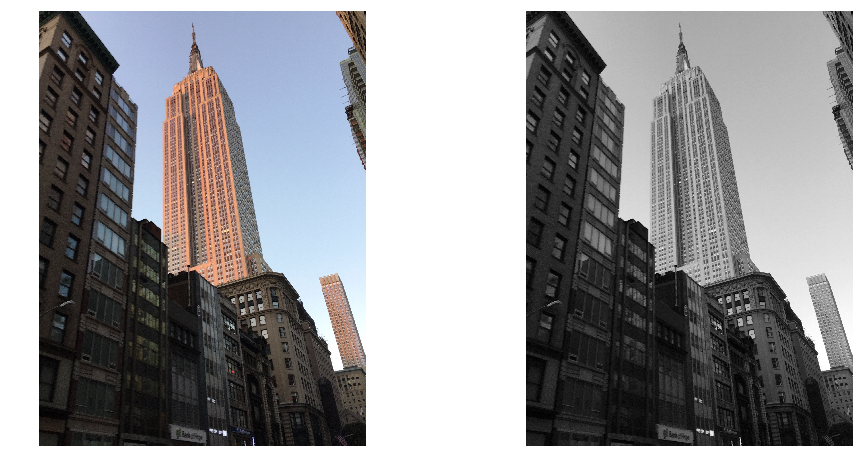

In [2]:
img = Image.open("images/IMG_1441.jpg")
img_gray = img.convert("L")   # convert to grayscale
img = np.array(img)
img_gray = np.array(img_gray)

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_gray, cmap="gray")

img = img_gray   # use grayscale as final
img = img/255

### Convolution

Convolution is the central operation in this pipeline. We can convolve the image with various kernels to blur the image and detect edges. We implement a convolution function to convolve any 2D matrix with a kernel.

In [3]:
def convolution(img, kernel):
    """Returns the convolution of img with kernel."""
    
    img_shape = img.shape
    result = np.zeros(img_shape)
    kernel_size = kernel.shape[0]
    pad_size = int((kernel_size - 1) / 2)
    img = np.pad(img, (pad_size, pad_size), "edge")   # padding to match kernel size
    for i in range(0, img_shape[0]):
        for j in range(0, img_shape[1]):
            val = np.sum(img[i:i + kernel_size, j:j + kernel_size] * kernel)
            result[i, j] = val
    return result

Use convolution to blur the image with a simple blur filter. This step denoises the image and makes it easier to detect edges.

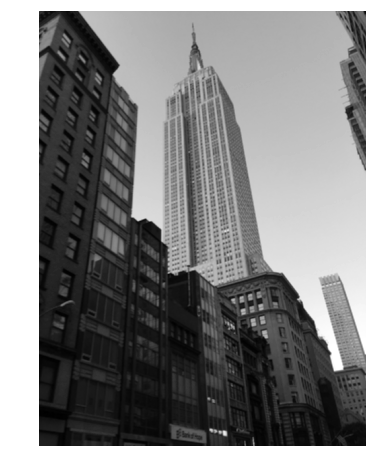

In [4]:
blur_filter = 1/169 * np.ones([13, 13])
img_blurred = convolution(img, blur_filter)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(img_blurred, cmap="gray")

### Edge detection

We implement edge detection with two convolutions: by convolving the image with the horizontal and vertical [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator). The Sobel filters approximate the gradient of the image in the horizontal and vertical directions, which correspond to edges in the image. We combine the convolutions for both directions by taking their magnitude. We also compute the direction of the gradient from the convolutions.

This gives us an idea of the magnitude and direction of the edges in the image.

In [5]:
def edge_detection(img):
    """Returns the magnitude and direction of the edges in img"""
    
    sobel_filter_horizontal = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_filter_vertical = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_gradient_x = convolution(img, sobel_filter_horizontal)
    img_gradient_y = convolution(img, sobel_filter_vertical)
    img_gradient_magnitude = ((img_gradient_x ** 2) + (img_gradient_y ** 2)) ** (1/2)
    img_gradient_direction = np.arctan2(img_gradient_x, img_gradient_y)
    return img_gradient_magnitude, img_gradient_direction

Now, we can detect edges in the blurred image.

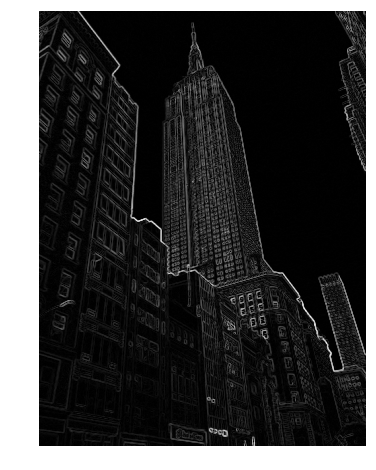

In [91]:
img_edge_magnitude, img_edge_direction = edge_detection(img_blurred)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(img_edge_magnitude, cmap="gray")

Threshold the edge magnitudes to make edges more prominent.

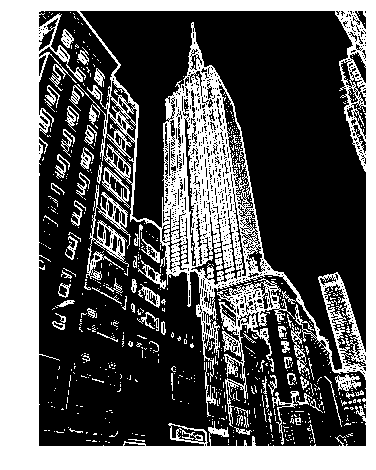

In [92]:
threshold = 0.06
img_edge_magnitude_thresholded = (img_edge_magnitude > threshold)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(img_edge_magnitude_thresholded, cmap="gray")

We can also visualize the direction of the edges. This will be useful when coloring the edges, because we want edges in the same direction (same angle) to have the same color.

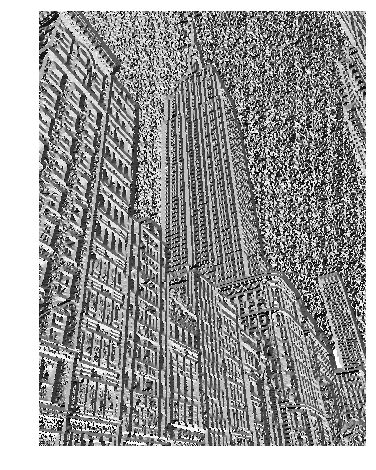

In [93]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(img_edge_direction, cmap="gray")

### Coloring

To color the edges, we take the thresholded edge image and convert it from grayscale to RGB using colors based on the direction of the edge pixels. For each pixel in the image, we check if it is an edge (if the thresholded edge pixel is 1). If it is not an edge pixel, we add a black pixel to the resulting RGB image, which results in a black background. If it is an edge pixel, we use the edge direction at that pixel to select a color from a color range (cmap), and we add that color pixel to the resulting RGB image.

In [118]:
def edge_color(img_edge_magnitude, img_edge_direction, cmap):
    """Colors the edges of the image using their direction and a colormap."""
    
    img_shape = img_edge_magnitude.shape
    img_edge_direction = img_edge_direction + abs(img_edge_direction.min())
    img_edge_direction_max = img_edge_direction.max()
    color_range = plt.cm.get_cmap(cmap)
    print(color_range)
    black_pixel = np.array([0, 0, 0])
    result = np.zeros((img_shape[0], img_shape[1], 3))
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            if img_edge_magnitude[i, j] == 1:
                # if edge is present, select a color based on the edge direction
                color_index = img_edge_direction[i, j] / img_edge_direction_max
                result[i, j] = color_range(color_index)[:3]
            else:   # if edge is not present, just add a black pixel
                result[i, j] = black_pixel
    return result

Finally, we can color the thresholded edge image to get our result.

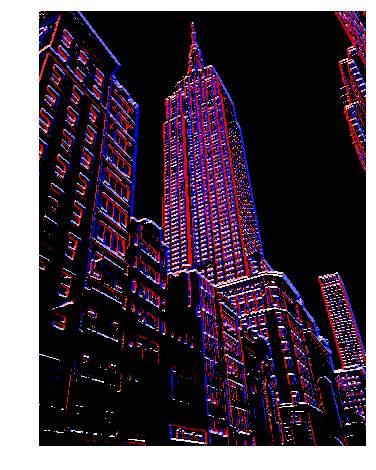

In [153]:
img_edge_colored = edge_color(img_edge_magnitude_thresholded, img_edge_direction, "seismic")
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(img_edge_colored)

In [156]:
img_edge_colored = Image.fromarray((img_edge_colored * 255).astype('uint8'))
img_edge_colored.save('results/9.jpg')

### Color all images

Color all images in images/ and store results in the results/ directory.

In [12]:
image_files = glob.glob("images/*")
results_dir = "results/"

blur_filter = 1/169 * np.ones([13, 13])
threshold = 0.06
cmaps = ["viridis", "plasma", "inferno", "magma"]

for i, f in enumerate(image_files):
    # Load image
    img = Image.open(f)
    img = img.convert("L")   # convert to grayscale
    img = np.array(img)
    img = img/255
    # Blur image
    img_blurred = convolution(img, blur_filter)
    # Detect edges
    img_edge_magnitude, img_edge_direction = edge_detection(img_blurred)
    img_edge_magnitude_thresholded = (img_edge_magnitude > threshold)
    img_edge_colored = edge_color(img_edge_magnitude_thresholded, img_edge_direction, cmaps[i%len(cmaps)])
    #Plot
    plt.figure(figsize=(40,16))
    plt.subplot(5, 2, i+1)
    plt.axis("off")
    plt.imshow(img_edge_colored)
    # Save to file
    img_edge_colored = Image.fromarray((img_edge_colored * 255).astype('uint8'))
    img_edge_colored.save("%s%s.jpg" % (results_dir, str(i)))

Color some more images.

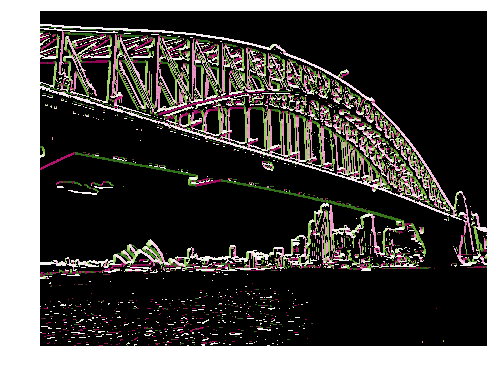

In [177]:
blur_filter = 1/169 * np.ones([13, 13])
threshold = 0.1
cmap='PiYG'

img = Image.open('images/bridge3.jpg')
img = img.convert("L")   # convert to grayscale
img = np.array(img)
img = img/255
# Blur image
img_blurred = convolution(img, blur_filter)
# Detect edges
img_edge_magnitude, img_edge_direction = edge_detection(img_blurred)
img_edge_magnitude_thresholded = (img_edge_magnitude > threshold)
img_edge_colored = edge_color(img_edge_magnitude_thresholded, img_edge_direction, cmap)
#Plot
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(img_edge_colored)
# Save to file
img_edge_colored = Image.fromarray((img_edge_colored * 255).astype('uint8'))
img_edge_colored.save('results/12.jpg')